In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mstda import FeatureSpace

In [2]:
fs = FeatureSpace.load("spaces/persistence_entropy_epsilon0.04.json")

# drop rows which dont have a feature vector
df = pd.read_csv("data/Drugbank_some_descriptors.csv")
idxs = list()
seen = set()
for idx,m in enumerate(df["SMILES"]):
    if (fs.get_feature_vector(m) is None) or (m in seen):
        idxs.append(idx)
        
    seen = seen.union({ m })
    
df = df.drop(idxs)

# drop rows which dont have data for descriptor which we are predicting
#desc ="ACD Descriptors;logP"
#desc = "Polarizability"
desc = "Mol Weight"

select = np.asarray(df[desc].isna())
idxs = np.asarray(df[desc].index)
df = df.drop(idxs[select])

# crossval
train_dataset = df.sample(frac=0.8)
test_dataset = df.drop(train_dataset.index)

In [3]:
train_idxs = [ fs.molecules.index(m) for m in train_dataset["SMILES"] ]
test_idxs = [ fs.molecules.index(m) for m in test_dataset["SMILES"] ]
train_features = fs.features[train_idxs, :]
test_features = fs.features[test_idxs, :]
print(train_features.shape, test_features.shape)

train_labels = np.asarray(train_dataset[desc])
print("train labels", "µ",np.mean(train_labels), "σ",np.std(train_labels))

test_labels = np.asarray(test_dataset[desc])
print("test labels", "µ",np.mean(test_labels), "σ",np.std(test_labels))

test_labels

(7761, 9) (1940, 9)
train labels µ 373.4872025842592 σ 252.53269935833623
test labels µ 374.76561213817746 σ 245.23711976435806


array([1069.21691895, 1019.23931885,  398.43737793, ...,  401.39645386,
        495.61532593,  428.45495605])

In [4]:
dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(train_features.shape[1:][0], input_shape = train_features.shape[1:]),
    tf.keras.layers.Dense(1),
])
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 90        
                                                                 
 dense_1 (Dense)             (None, 1)                 10        
                                                                 
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________


2021-12-22 10:48:53.000467: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-22 10:48:54.096553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6765 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [5]:
dense_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate = .1),
    loss = "mean_absolute_error"
)

In [6]:
%%time
history = dense_model.fit(
    train_features,
    train_labels,
    verbose = 0,
    epochs = 100,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

CPU times: user 29.2 s, sys: 2.75 s, total: 32 s
Wall time: 21.6 s


In [7]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

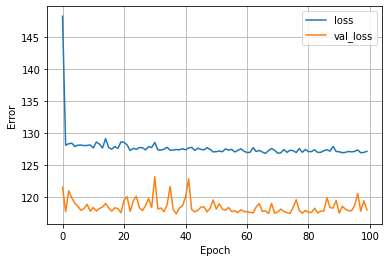

In [8]:
plot_loss(history)

In [9]:
dense_model.evaluate(test_features, test_labels, verbose=1)

61/61 [==============================] - 0s 878us/step - loss: 125.3649


125.36486053466797